In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
from sklearn import preprocessing


In [2]:
df = pd.read_csv('ss_curves.csv')
df1 = pd.read_csv("case1.csv", skiprows = 2)

In [33]:
def format_curve(sim_stress, sim_strain):
    prune = np.logical_and(sim_strain > x_min, sim_strain < x_max)
    sim_stress = sim_stress[prune]
    sim_strain = sim_strain[prune]
    exp_stress_intrpl = f(sim_strain)
    return exp_stress_intrpl

def preprocess_case1(df):
    stress = np.array([df[col] for col in df.columns if "MPa" in col])
    strain = np.array([df[col] for col in df.columns if "plastic" in col])
    labels = ["Experimental"] + [f"Simulated {i}" for i in range(1, len(stress)+1)]
    print(stress.shape, strain.shape)
    plot(stress, strain, labels)
    # Cut the excess values above and below the experimental values.
    exp_strain = np.nan_to_num(strain[0])
    x_min, x_max = 0.005, exp_strain.max() # !!! CHANGED to 0.005 and rerun
    f = interp1d(exp_strain, stress[0])
    x_y = []
    for (sim_strain, sim_stress) in zip(strain[1:,:],stress[1:,:]):
        # Indices to prune simulated curves by
        prune = np.logical_and(sim_strain > x_min, sim_strain < x_max)
        sim_stress = sim_stress[prune]
        sim_strain = sim_strain[prune]
        # Linear Interpolation
        exp_stress = f(sim_strain) # The target curve
        x_y.append(tuple((sim_strain, sim_stress, exp_stress)))
    return x_y
        
def getTruePlasticStrain(strain, stress):
    # Getting the slope
    slope = (stress[1] - stress[0]) / (strain[1] - strain[0])
    true_plastic_strain = strain - stress / slope
    return true_plastic_strain

def preprocess(df): # Case 2
    stress = np.array([df[col] for col in df.columns if "stress" in col])
    strain = np.array([df[col] for col in df.columns if "strain" in col])
    labels = ["Experimental"] + [f"Simulated {i}" for i in range(1, len(stress)+1)]

    # Cut the excess values above and below the experimental values.
    exp_strain = strain[0]
    x_min, x_max = 0.002, exp_strain.max()
    prune = np.logical_and(strain[1] > x_min, strain[1] < x_max)  # Indices to prune simulated curves by
    sim_stress = stress[1:][:, prune]
    sim_strain = strain[1:][:, prune]
    # Linear Interpolation
    f = interp1d(exp_strain, stress[0])
    exp_stress = f(sim_strain[0]) # The target curve
    out = []
    for (stress, strain) in zip(sim_stress, sim_strain):
        out.append((strain, stress, exp_stress))
    return out


def plot(stress, strain, label):
    plt.figure(figsize=(20,12))
    for x,y,label in zip(strain,stress,label):
        plt.plot(x, y, label=label)
    plt.xlim([0,0.075])
    plt.ylim([0,2000])
    plt.vlines(strain[0].max(), 0, 1100, linestyle='dotted')
    plt.legend()
    plt.show()
    
def elastic(stress, strain, trueStrain):

    # Obtain the elastic stress and strain based on r-squared

    trimValue = np.arange(0.001, 0.02, 0.00001)
    trimValue = np.flip(trimValue)
    r2 = 0.00
    elasticTrueStrain = trueStrain
    elasticStrain = strain
    elasticStress = stress
    while(r2 <= 0.95):
        for x in trimValue:
            val = np.argmax(strain >= x)
            elasticTrueStrain = trueStrain[0:val]
            elasticStrain = strain[0:val]
            elasticStress = stress[0:val]
            r2 = adjR(elasticStrain, elasticStress, 1)


    return elasticStress, elasticStrain, elasticTrueStrain


def adjR(x, y, degree):
    results = []
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    results = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))
    return results


ValueError: too many values to unpack (expected 4)

In [34]:
#x_ysim_yexp = preprocess_case1(df1)
x_ysim_yexp = preprocess(df)

In [35]:
[len(x) for x,_,_ in x_ysim_yexp]

[344, 344, 344, 344, 344, 344, 344]

In [40]:
# D1 loss function: L2 loss 
def D1(exp_stress, sim_stress): 
    return np.sqrt(np.sum(np.square(exp_stress - sim_stress))/np.sum(np.square(exp_stress)))

def D2(exp_stress, sim_stress, strainobj): # Added strainobj as an input
    exp_stress_d1 = np.diff(exp_stress)/np.diff(strainobj)  
    sim_stress_d1 = np.diff(sim_stress)/np.diff(strainobj)
    return np.sqrt(np.sum(np.square(sim_stress_d1 - exp_stress_d1))/np.sum(np.square(exp_stress_d1)))

def D3(exp_stress, sim_stress):
    return np.max(np.sqrt(np.square(exp_stress - sim_stress)/sum(np.square(exp_stress))))

def D4(exp_stress, sim_stress, strainobj):
    exp_stress_d1 = np.diff(exp_stress)/np.diff(strainobj)
    sim_stress_d1 = np.diff(sim_stress)/np.diff(strainobj)
    return max(np.sqrt(np.square(sim_stress_d1 - exp_stress_d1)/np.sum(np.square(exp_stress_d1))))

def fitness(exp_stress, sim_stress,strainobj, w1, w2, w3, w4):
    return ( w1*D1(exp_stress, sim_stress) + w2*D2(exp_stress, sim_stress, strainobj) 
            + w3*D3(exp_stress, sim_stress) + w4*D4(exp_stress, sim_stress, strainobj))

# Testing on every index of sigma_hats
resD1 = []
resD2 = []
resD3 = []
resD4 = []
res_fit = []

w1 = 0.9
w2 = 0.001
w4 = 0.001
w3 = 1 - w1 - w2 - w4

for (strain, sim_stress, exp_stress) in x_ysim_yexp:
    resD1.append(D1(exp_stress, sim_stress))
    resD2.append(D2(exp_stress, sim_stress, strain))
    resD3.append(D3(exp_stress, sim_stress))
    resD4.append(D4(exp_stress, sim_stress, strain))
    res_fit.append(fitness(exp_stress, sim_stress, strain, w1, w2, w3, w4))

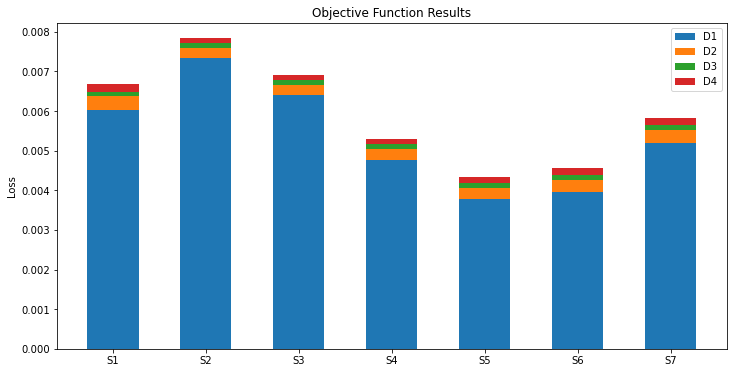

In [41]:
labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']

width = 0.55       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(12,6))
L1 = np.array(resD1)*w1
L2 = np.array(resD2)*w2
L3 = np.array(resD3)*w3
L4 = np.array(resD4)*w4

ax.bar(labels, L1, width, label='D1')
ax.bar(labels, L2, width, bottom=L1 , label='D2')
ax.bar(labels, L3, width, bottom=L1+L2, label='D3')
ax.bar(labels, L4, width, bottom=L1+L2+L3, label='D4')

ax.set_ylabel('Loss')
ax.set_title('Objective Function Results')
ax.legend()

plt.show()